## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf

## Define Functions

In [2]:
def getGloveCorpus(dims=300):
    # Set path and load corpus
    path = '../data/embedings/'
    filename = f'glove.6B.{dims}d.txt'
    f = open(path+filename, 'r', encoding='latin2')
    vec_txt = f.read()

    vec_data = {}
    words = vec_txt.split('\n')
    for word in words:
        vec = word.split()
        if len(vec) == dims+1:
            vec_data[vec[0]] = np.array([np.float16(x) for x in vec[1:]])
    vec = pd.DataFrame(vec_data, columns=None).transpose()
    return vec


def cleanText(textData):
    clean = []
    stops = set(stopwords.words('english'))
    
    for text in textData:
        # convert to lowercase
        cleanText = text.strip()
        cleanText = cleanText.lower()
        cleanText = word_tokenize(cleanText)
        cleanText = [word for word in cleanText if word not in stops]
        cleanText = " ".join(cleanText)
        cleanText = cleanText.replace('\n', " ")
        cleanText = re.sub(r"(?:^|\W)utc(?:$|\W)", '', cleanText)
        cleanText = re.sub(r'http[s]*://[A-Za-z0-9:./?=]*', 'url', cleanText)
        cleanText = re.sub(r"[^a-z\s]", '', cleanText)
        cleanText = re.sub(r'[\s]+', " ", cleanText)
        clean.append(cleanText)

    return clean

def getGloveVec(word, vec, dims=300):
    vc = np.zeros(dims)
    try:
        vc = np.array(vec.loc[word])
    except:
        vc = np.zeros(dims)
    return vc


def getDocVec(sentence, vec, dims):
    tokens = word_tokenize(sentence)
    vecs = np.zeros(dims)
    for word in tokens:
        vecs += getGloveVec(word, vec, dims)
    return vecs


def getVecForm(X, Y, dims, vec, reshaping=None):
    '''
    X - Array of sentences.
    Y - Array of output class (numeric).
    dims - Vector dimensions (needed to pad correctly).
    '''
    vecList = []
    for i in X:
        vecList.append(getDocVec(i, vec, dims))
    X = np.asarray(vecList).astype(np.float16)
    Y = np.asarray(Y).astype(np.float16)
    if reshaping != None:
        X = np.reshape(X, reshaping)
    return X, Y


## Set Configuration

In [3]:
PATH = '../data/'
DIMS = 300
MAXVECLEN = 40
DATASET = 'jigsaw-toxic-comment-classification-challenge/train.csv'
TEXT = 'comment_text'
CLASS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
EPOCH = 15
SPLIT = 0.25

## Read GloVe Data

In [4]:
VEC = getGloveCorpus(dims=DIMS)
VEC

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.046570,0.213135,-0.007435,-0.458496,-0.035645,0.236450,-0.288330,0.215210,-0.134888,-1.641602,...,-0.013062,-0.296875,-0.079895,0.194946,0.031555,0.285156,-0.087463,0.009064,-0.209839,0.053925
",",-0.255371,-0.257324,0.131714,-0.042694,0.218140,-0.022705,-0.178589,0.107544,0.058929,-1.385742,...,0.075989,-0.014359,-0.073792,0.221802,0.146484,0.566895,0.053314,-0.232910,-0.122253,0.354980
.,-0.125610,0.013634,0.103088,-0.101257,0.098145,0.136230,-0.107239,0.236938,0.328613,-1.678711,...,0.060150,-0.156250,-0.119507,0.234497,0.081360,0.246216,-0.152466,-0.342285,-0.022400,0.136841
of,-0.076965,-0.021210,0.212769,-0.722168,-0.139893,-0.122314,-0.175171,0.121399,-0.070862,-1.572266,...,-0.366699,-0.385986,0.302979,0.015747,0.340332,0.478516,0.068604,0.183472,-0.291748,-0.046539
to,-0.257568,-0.057129,-0.671875,-0.380859,-0.364258,-0.082153,-0.010956,-0.082031,0.460449,-1.847656,...,-0.012810,-0.597168,0.317383,-0.252686,0.543945,0.062988,-0.049805,-0.160400,0.046753,-0.070618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,0.392578,-0.022507,0.304688,0.187988,0.141235,0.724121,-0.257812,-0.137329,-0.016525,0.596191,...,-0.182983,0.406738,-0.343750,-0.270508,-0.593750,0.016449,0.140747,0.463867,-0.369629,-0.287109
kronik,0.136841,-0.139038,-0.360840,0.079834,0.321533,0.263916,-0.109924,0.044434,0.083862,0.791504,...,0.036407,-0.036835,-0.348145,0.064758,-0.000577,-0.133789,0.428955,-0.023315,0.410156,-0.393066
rolonda,0.075684,-0.040497,0.183472,0.512207,-0.228516,0.838867,0.178833,-0.712891,0.326904,0.695312,...,-0.388428,0.545898,-0.035065,-0.184326,-0.197021,-0.350098,0.160645,0.218384,0.309570,0.437500
zsombor,0.814453,-0.362305,0.311768,0.813965,0.188477,-0.313721,0.827637,0.296631,-0.085510,0.476074,...,0.130859,0.106140,-0.408203,0.313477,-0.430176,0.069824,-0.207642,0.075500,0.284180,-0.175537


## Import Dataset

In [5]:
df = pd.read_csv(PATH+DATASET).drop(columns=['id']).dropna().reset_index(drop=True)
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Clean Text

In [6]:
df[TEXT] = cleanText(df[TEXT])
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,daww matches background colour m seemingly stu...,0,0,0,0,0,0
2,hey man m really trying edit war s guy constan...,0,0,0,0,0,0
3,ca nt make real suggestions improvement wonde...,0,0,0,0,0,0
4,sir hero chance remember page s,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,second time asking view completely contradict...,0,0,0,0,0,0
159567,ashamed horrible thing put talk page,0,0,0,0,0,0
159568,spitzer umm theres actual article prostitution...,0,0,0,0,0,0
159569,looks like actually put speedy first version d...,0,0,0,0,0,0


In [7]:
X_, Y_ = df[TEXT], df[CLASS]

In [8]:
Y_

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


## Simple NN

### Convert dataset into Word Vector

In [9]:
X, Y = getVecForm(
    X = X_,
    Y = Y_,
    vec = VEC,
    dims=DIMS
)

In [10]:
X.shape

(159571, 300)

In [11]:
Y

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float16)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

### Training a Simple NN

In [13]:
def simpleNN(X, Y):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        128, activation='relu', input_shape=X.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(Y.shape[1], activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
snn = simpleNN(X, Y)
history = snn.fit(x_train, y_train, validation_split=SPLIT, epochs=EPOCH)

Epoch 1/15
2805/2805 [==============================] - 12s 4ms/step - loss: 0.5747 - accuracy: 0.2251 - val_loss: 0.4812 - val_accuracy: 0.9017
Epoch 2/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.8325 - accuracy: 0.2146 - val_loss: 0.4112 - val_accuracy: 0.9548
Epoch 3/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.9313 - accuracy: 0.2086 - val_loss: 0.4029 - val_accuracy: 0.9261
Epoch 4/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.9727 - accuracy: 0.2067 - val_loss: 0.3786 - val_accuracy: 0.6962
Epoch 5/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.9455 - accuracy: 0.2095 - val_loss: 0.4179 - val_accuracy: 0.0289
Epoch 6/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.8825 - accuracy: 0.2137 - val_loss: 0.3897 - val_accuracy: 0.9037
Epoch 7/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.7934 - accuracy: 0.2251 - val_loss: 0.3697 - val_ac

In [15]:
snn.evaluate(x_test, y_test)

1247/1247 [==============================] - 3s 2ms/step - loss: 0.3739 - accuracy: 0.9826


[0.3739440143108368, 0.9826034903526306]

### Loss History

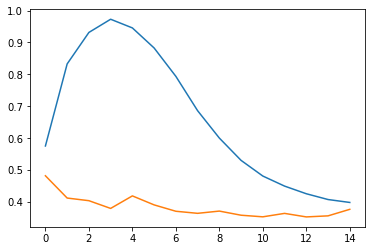

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### Accuracy History

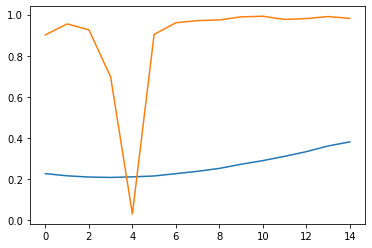

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [18]:
snn.save('SNN.h5')

### Training a Simple NN with TanH

In [19]:
def simpleNNtanh(X, Y):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        128, activation='relu', input_shape=X.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(Y.shape[1], activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model

In [20]:
snnth = simpleNNtanh(X, Y)
history = snnth.fit(x_train, y_train, validation_split=SPLIT, epochs=EPOCH)

Epoch 1/15
2805/2805 [==============================] - 12s 4ms/step - loss: 0.6330 - accuracy: 0.1994 - val_loss: 0.3907 - val_accuracy: 0.0058
Epoch 2/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.8869 - accuracy: 0.2069 - val_loss: 0.3841 - val_accuracy: 0.0084
Epoch 3/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.9646 - accuracy: 0.2143 - val_loss: 0.3743 - val_accuracy: 0.2599
Epoch 4/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.9904 - accuracy: 0.2211 - val_loss: 0.3914 - val_accuracy: 0.0261
Epoch 5/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.9744 - accuracy: 0.2261 - val_loss: 0.4139 - val_accuracy: 0.0109
Epoch 6/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.8785 - accuracy: 0.2392 - val_loss: 0.4306 - val_accuracy: 0.0116
Epoch 7/15
2805/2805 [==============================] - 11s 4ms/step - loss: 0.7968 - accuracy: 0.2548 - val_loss: 0.3959 - val_ac

In [21]:
snnth.evaluate(x_test, y_test)

1247/1247 [==============================] - 2s 2ms/step - loss: 0.3432 - accuracy: 0.9942


[0.3431628942489624, 0.9941594004631042]

### Loss History

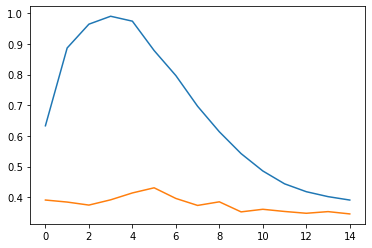

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### Accuracy History

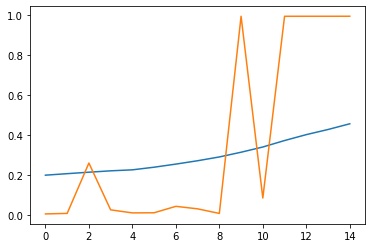

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [24]:
snnth.save('SNNTanH.h5')

## LSTM

### Convert dataset into Word Vector

In [25]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
X.shape

(159571, 1, 300)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

### Training a LSTM

In [27]:
def simpleLSTM(X, Y):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(8, input_shape=X.shape[1:]))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(Y.shape[1], activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model

In [28]:
lstms = simpleLSTM(X, Y)
history = lstms.fit(x_train, y_train, validation_split=SPLIT, epochs=EPOCH)

Epoch 1/15
2805/2805 [==============================] - 16s 5ms/step - loss: 0.1584 - accuracy: 0.7435 - val_loss: 0.0759 - val_accuracy: 0.9899
Epoch 2/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0727 - accuracy: 0.9904 - val_loss: 0.0705 - val_accuracy: 0.9917
Epoch 3/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0694 - accuracy: 0.9915 - val_loss: 0.0693 - val_accuracy: 0.9916
Epoch 4/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0679 - accuracy: 0.9910 - val_loss: 0.0683 - val_accuracy: 0.9933
Epoch 5/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0664 - accuracy: 0.9921 - val_loss: 0.0692 - val_accuracy: 0.9937
Epoch 6/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0648 - accuracy: 0.9924 - val_loss: 0.0689 - val_accuracy: 0.9936
Epoch 7/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0642 - accuracy: 0.9927 - val_loss: 0.0681 - val_ac

In [29]:
lstms.evaluate(x_test, y_test)

1247/1247 [==============================] - 3s 2ms/step - loss: 0.0682 - accuracy: 0.9924


[0.06815150380134583, 0.9924046993255615]

### Loss History

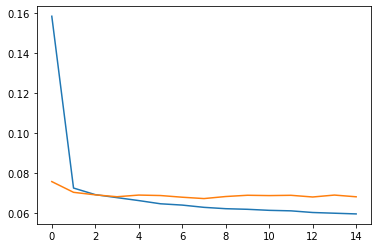

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### Accuracy History

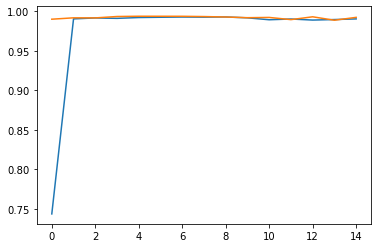

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [32]:
lstms.save('LSTM.h5')

### Training LSTM with TanH

In [33]:
def simpleLSTMtanh(X, Y):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(8, input_shape=X.shape[1:]))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(Y.shape[1], activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model

In [34]:
lstmth = simpleLSTMtanh(X, Y)
history = lstmth.fit(x_train, y_train, validation_split=SPLIT, epochs=EPOCH)

Epoch 1/15
2805/2805 [==============================] - 16s 5ms/step - loss: 0.1635 - accuracy: 0.5227 - val_loss: 0.0723 - val_accuracy: 0.9932
Epoch 2/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0708 - accuracy: 0.9291 - val_loss: 0.0685 - val_accuracy: 0.9937
Epoch 3/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0670 - accuracy: 0.9623 - val_loss: 0.0670 - val_accuracy: 0.9935
Epoch 4/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0645 - accuracy: 0.9753 - val_loss: 0.0673 - val_accuracy: 0.9930
Epoch 5/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0629 - accuracy: 0.9763 - val_loss: 0.0667 - val_accuracy: 0.9931
Epoch 6/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.0670 - val_accuracy: 0.9933
Epoch 7/15
2805/2805 [==============================] - 13s 5ms/step - loss: 0.0607 - accuracy: 0.9850 - val_loss: 0.0661 - val_ac

In [35]:
lstmth.evaluate(x_test, y_test)

1247/1247 [==============================] - 3s 2ms/step - loss: 0.0660 - accuracy: 0.9931


[0.06603048741817474, 0.9930815100669861]

### Loss History

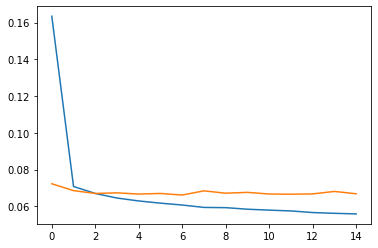

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### Accuracy History

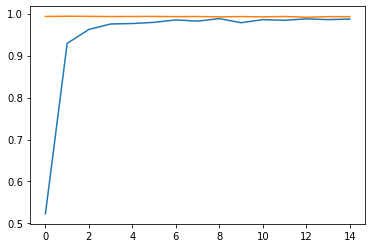

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [38]:
lstmth.save('LSTMTanH.h5')

In [40]:
sentence = 'Hello I am not toxic'

def preprocess(sentence, VEC=VEC, DIMS=DIMS, reshape=False):
    X = cleanText([sentence])
    X = getDocVec(sentence=X[0], vec=VEC, dims=DIMS)
    X = np.asarray([X]).astype(np.float16)
    if reshape:
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    return X

print(lstms.predict(preprocess(sentence, reshape=True)))
print(lstmth.predict(preprocess(sentence, reshape=True)))
print(snn.predict(preprocess(sentence)))
print(snnth.predict(preprocess(sentence)))

[[0.16849567 0.00056785 0.01589252 0.00045656 0.03464931 0.00144142]]
[[0.14389637 0.00235194 0.03550495 0.00114327 0.03132157 0.00138212]]
[[0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]]
